## 4. Гамильтониан Джейнса-Каммингса-Хаббарда. Утечка фотонов из полостей

<b>Задача:</b> <em>Дана система $n>1$ полостей, соединенных волноводами с одинаковой вещественной пропускной способностью, в каждой - по одному атому. Выбрав нетривиальное начальное условие, решить задачу Коши для квантового основного уравнения и гамильтониана Джейнса-Каммингса-Хаббарда (в усложненном случае Тависа-Каммингса-Хаббарда, с несколькими атомами в одной полости), с единственным фактором декогерентности - утечкой фотона из одной из полостей: $A=a_k$.</em>

Для некоторого упрощения задачи будем работать в приближении RWA, соответственно, энергия будет сохраняться. Гамильтониан Джейнса-Каммингса-Хаббарда-RWA для двух полостей:

$H = \hbar \omega (a_1^\dagger a_1 + a_2^\dagger a_2) + \hbar \omega (\sigma_1^\dagger\sigma_1+\sigma_2^\dagger\sigma_2) + g (a_1^\dagger\sigma_1 + a_2^\dagger\sigma_2) + g (a_1\sigma^\dagger_1 + a_2\sigma^\dagger_2) + \mu (a_1^\dagger a_2 + a_1 a_2^\dagger)$

<b>Фотон взаимодействует только с атомами "своей" полости! </b>

То есть придется считать матричные элементы от операторов:

- $a_i^\dagger a_i$

- $\sigma_n^\dagger \sigma_n$

- $\sigma_n^\dagger a_i$

- $\sigma_n a_i^\dagger$

- $a_i^\dagger a_j$

Можно упростить вычисление матричных элементов еще сильнее, если вспомнить, что первые два оператора суть операторы числа частиц, а для третьего и четвертого операторов возможна факторизация, т.к. каждый оператор рождения/уничтожения будет действовать только на "свою" частицу.

Базисный набор строится для заданной энергии $E = N \hbar \omega$, и включает только такие векторы $|n_1n_2,m_1m_2>$, для которых $n_1+n_2+m_1+m_2 = N$, при этом $m_1,m_2=0,1$. Все приведенные соображения позволяют легко строить гамильтонианы для абсолютно произвольного числа полостей и атомов в них.

In [1]:
from math import *
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt

In [2]:
# for the case of 1 atom per cavity
# energy is in the hw units
def define_basis(max_energy):
    
    basis_states = []
    
    for n1 in range(0,max_energy+1):
        for n2 in range(0,max_energy+1):
            for m1 in range(0,2):
                for m2 in range(0,2):
                    if n1+n2+m1+m2 == max_energy:
                        basis_states.append(np.array([n1,n2,m1,m2], dtype=np.int))
    
    return basis_states

def print_basis(basis_states):
    print('basis states:')
    for i,state in enumerate(basis_states):
        print('[%3d]' % (i), state)

def kron_delta(i,j):
    if i == j:
        return 1
    else:
        return 0

def eigensolver(H):
    e, v = linalg.eig(H)
    idx = e.argsort()[::1]   
    e = e[idx]
    v = v[:,idx]
    return e, v

def self_energy_atom(state_1, state_2, n_ph, n_at, atom_index):
    if (state_1 == state_2).all():
        return state_1[n_ph + atom_index]
    else:
        return 0.0
    
def self_energy_photon(state_1, state_2, n_ph, n_at, photon_index):
    if (state_1 == state_2).all():
        return state_1[photon_index]
    else:
        return 0.0

def annihil_atom(state_1, state_2, n_ph, n_at, atom_index):
    new_state_2 = np.copy(state_2)
    new_state_2[n_ph + atom_index] -= 1
    if (state_1[n_ph:] == new_state_2[n_ph:]).all():
        return 1.0
    else:
        return 0.0

def create_atom(state_1, state_2, n_ph, n_at, atom_index):
    new_state_2 = np.copy(state_2)
    new_state_2[n_ph + atom_index] += 1
    if (state_1[n_ph:] == new_state_2[n_ph:]).all():
        return 1.0
    else:
        return 0.0

def annihil_photon(state_1, state_2, n_ph, n_at, photon_index):
    new_state_2 = np.copy(state_2)
    new_state_2[photon_index] -= 1
    if (state_1[:n_ph] == new_state_2[:n_ph]).all():
        n = state_2[photon_index]
        return sqrt(n)
    else:
        return 0.0

def create_photon(state_1, state_2, n_ph, n_at, photon_index):
    new_state_2 = np.copy(state_2)
    new_state_2[photon_index] += 1
    if (state_1[:n_ph] == new_state_2[:n_ph]).all():
        n = state_2[photon_index]
        return sqrt(n+1)
    else:
        return 0.0

# a \sigma^\dagger
def exc_atom(state_1, state_2, n_ph, n_at, photon_index, atom_index):
    return annihil_photon(state_1, state_2, n_ph, n_at, photon_index) * create_atom(state_1, state_2, n_ph, n_at, atom_index)

# a^\dagger \sigma
def deexc_atom(state_1, state_2, n_ph, n_at, photon_index, atom_index):
    return create_photon(state_1, state_2, n_ph, n_at, photon_index) * annihil_atom(state_1, state_2, n_ph, n_at, atom_index)

def photon_exchange(state_1, state_2, n_ph, n_at, photon1_index, photon2_index):
    state_1 = state_1[:n_ph]
    state_2 = state_2[:n_ph]
    new_state_2 = np.copy(state_2)
    new_state_2[photon1_index] += 1
    new_state_2[photon2_index] -= 1
    if (state_1 == new_state_2).all():
        n1 = state_2[photon1_index]
        n2 = state_2[photon2_index]
        return sqrt(n2) * sqrt(n1+1)
    else:
        return 0.0

# model: two cavities, 1 atom per cavity
def hamiltonian_jch(basis_states, g=0.0, mu=0.0):
    dim = len(basis_states)
    H = np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(0,dim):
            state_1 = basis_states[i]
            state_2 = basis_states[j]
            H_ij = 0.0
            
            # diagonal
            H_ij += self_energy_atom(state_1, state_2, 2, 2, 0)
            H_ij += self_energy_atom(state_1, state_2, 2, 2, 1)
            H_ij += self_energy_photon(state_1, state_2, 2, 2, 0)
            H_ij += self_energy_photon(state_1, state_2, 2, 2, 1)

            # off-diagonal:
            # excitation of atoms
            H_ij += g*exc_atom(state_1, state_2, 2, 2, 0, 0)
            H_ij += g*exc_atom(state_1, state_2, 2, 2, 1, 1)
            # de-excitation of atoms
            H_ij += g*deexc_atom(state_1, state_2, 2, 2, 0, 0)
            H_ij += g*deexc_atom(state_1, state_2, 2, 2, 1, 1)
            # photon exchange
            H_ij += mu*photon_exchange(state_1, state_2, 2, 2, 0, 1)
            H_ij += mu*photon_exchange(state_1, state_2, 2, 2, 1, 0)
            
            H[i,j] = H_ij

    return H

Теперь можно строить динамику. Заведем инструменты для решения основного квантового уравнения (из предыдущих задач).

In [3]:
def runge_kutta_4(t,dim,fun,rho_0,gamma):

    npoints = len(t)
    rho_list = np.zeros((npoints, dim, dim), dtype=np.cdouble)
    rho = np.array(rho_0,dtype=np.cdouble)
    rho_list[0,:,:] = rho
    
    for i in range(1,npoints):

        h = t[i] - t[i-1]

        # Runge-Kutta
        k1 = fun(rho,gamma)
        k2 = fun(rho + 0.5*h*k1,gamma)
        k3 = fun(rho + 0.5*h*k2,gamma)
        k4 = fun(rho + h*k3,gamma)
        rho = rho + 1.0/6.0 * h * (k1 + 2*k2 + 2*k3 + k4)

        rho_list[i,:,:] = rho
    
    return rho_list

def fun_no_leaks(rho,gamma):
    return (-1j)*(np.matmul(H, rho) - np.matmul(rho,H))

Посмотрим сначала на простейшую модель. Две ячейки, два фотона. Обмена фотонами между ячейками нет. В начальный момент времени оба атома находятся в возбужденном состоянии (вектор $|00,11>$).

basis states:
[  0] [0 0 1 1]
[  1] [0 1 0 1]
[  2] [0 1 1 0]
[  3] [0 2 0 0]
[  4] [1 0 0 1]
[  5] [1 0 1 0]
[  6] [1 1 0 0]
[  7] [2 0 0 0]
H eigenvalues:
[  0]   1.98000000
[  1]   1.98585786
[  2]   1.98585786
[  3]   2.00000000
[  4]   2.00000000
[  5]   2.01414214
[  6]   2.01414214
[  7]   2.02000000


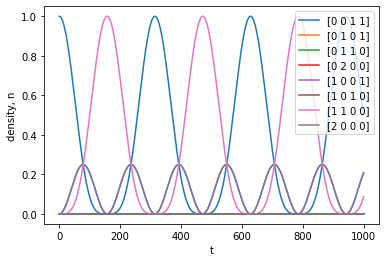

In [4]:
basis_states = define_basis(2)
basis_dim = len(basis_states)
print_basis(basis_states)

H = hamiltonian_jch(basis_states, g=0.01, mu=0.0)
E, v = eigensolver(H)
print('H eigenvalues:')
for i in range(0,basis_dim):
    print('[%3d] %12.8f' % (i, E[i]))

# initial guess: only the |00,11> state is populated
rho_0 = np.zeros((basis_dim,basis_dim))
rho_0[0,0] = 1.0

# dynamics
t = np.linspace(0,1000,1001)
rho_list = runge_kutta_4(t, basis_dim, fun_no_leaks, rho_0, 0.0)

# plot
for i in range(0,basis_dim):
    plt.plot(t, abs(rho_list[:,i,i]), label=str(basis_states[i]))
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('density, n')
plt.show()

Теперь включим обмен между полостями, но оставим лишь один атом возбужденным в первой ячейке ($E = \hbar\omega$). Сделаем взаимодействие атома с полем в несколько раз более сильным, чем взаимодействие между полостями.

basis states:
[  0] [0 0 0 1]
[  1] [0 0 1 0]
[  2] [0 1 0 0]
[  3] [1 0 0 0]
H eigenvalues:
[  0]   0.98895012
[  1]   0.99095012
[  2]   1.00904988
[  3]   1.01104988


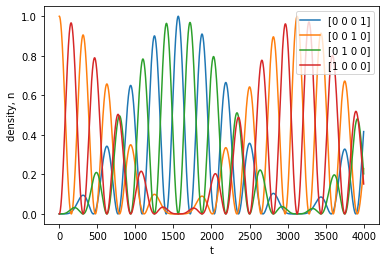

In [5]:
basis_states = define_basis(1)
basis_dim = len(basis_states)
print_basis(basis_states)

H = hamiltonian_jch(basis_states, g=0.01, mu=0.002)
E, v = eigensolver(H)
print('H eigenvalues:')
for i in range(0,basis_dim):
    print('[%3d] %12.8f' % (i, E[i]))

# initial guess: only the |00,11> state is populated
rho_0 = np.zeros((basis_dim,basis_dim))
rho_0[1,1] = 1.0

# dynamics
t = np.linspace(0,4000,4001)
rho_list = runge_kutta_4(t, basis_dim, fun_no_leaks, rho_0, 0.0)

# plot
for i in range(0,basis_dim):
    plt.plot(t, abs(rho_list[:,i,i]), label=str(basis_states[i]))
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('density, n')
plt.show()

Интерпретация графиков простая - фотон попеременно находится то в одной ячейке, то в другой, при этом происходят осцилляции Раби.

Динамика для двух фотонов ($E=2\hbar\omega$) гораздо сложнее:

basis states:
[  0] [0 0 1 1]
[  1] [0 1 0 1]
[  2] [0 1 1 0]
[  3] [0 2 0 0]
[  4] [1 0 0 1]
[  5] [1 0 1 0]
[  6] [1 1 0 0]
[  7] [2 0 0 0]
H eigenvalues:
[  0]   1.98005948
[  1]   1.98466125
[  2]   1.98740121
[  3]   1.99803920
[  4]   2.00007990
[  5]   2.01329955
[  6]   2.01455576
[  7]   2.02190364


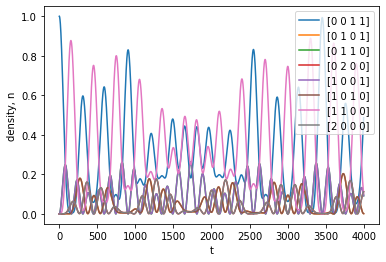

In [6]:
basis_states = define_basis(2)
basis_dim = len(basis_states)
print_basis(basis_states)

H = hamiltonian_jch(basis_states, g=0.01, mu=0.002)
E, v = eigensolver(H)
print('H eigenvalues:')
for i in range(0,basis_dim):
    print('[%3d] %12.8f' % (i, E[i]))

# initial guess: only the |00,11> state is populated
rho_0 = np.zeros((basis_dim,basis_dim))
rho_0[0,0] = 1.0

# dynamics
t = np.linspace(0,4000,4001)
rho_list = runge_kutta_4(t, basis_dim, fun_no_leaks, rho_0, 0.0)

# plot
for i in range(0,basis_dim):
    plt.plot(t, abs(rho_list[:,i,i]), label=str(basis_states[i]))
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('density, n')
plt.show()

Теперь введем утечку из первой ячейки. Для того, чтобы можно было разобраться в результате и его интерпретировать, посмотрим на наиболее простой случай одного фотона ($E=\hbar\omega$).

basis states:
[  0] [0 0 0 0]
[  1] [0 0 0 1]
[  2] [0 0 1 0]
[  3] [0 1 0 0]
[  4] [1 0 0 0]
H eigenvalues:
[  0]   0.00000000
[  1]   0.98895012
[  2]   0.99095012
[  3]   1.00904988
[  4]   1.01104988
Leak matrix:
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


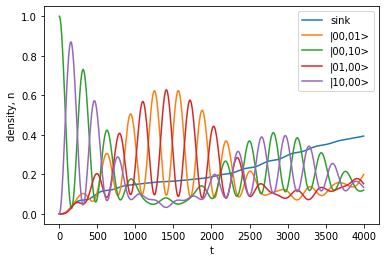

In [7]:
basis_labels = ['sink', '|00,01>', '|00,10>', '|01,00>', '|10,00>']
basis_states = [np.array([0,0,0,0])] + define_basis(1)
basis_dim = len(basis_states)
print_basis(basis_states)

H = hamiltonian_jch(basis_states, g=0.01, mu=0.002)
E, v = eigensolver(H)
print('H eigenvalues:')
for i in range(0,basis_dim):
    print('[%3d] %12.8f' % (i, E[i]))

# initial guess: only the |00,11> state is populated
rho_0 = np.zeros((basis_dim,basis_dim))
rho_0[2,2] = 1.0

# leak operator matrix (from the 1st cell)
A1 = np.zeros((basis_dim,basis_dim))
for i in range(0,basis_dim):
    for j in range(0,basis_dim):
        A1[i,j] = annihil_photon(basis_states[i], basis_states[j], 2, 2, photon_index=0)
print('Leak matrix:')
print(A1)

def fun_leak_1st(rho,gamma):
    A1conj = np.transpose(A1)
    A1conjA1 = np.matmul(A1conj, A1)
    L = gamma * (np.matmul(A1, np.matmul(rho, A1conj)) - 0.5 * (np.matmul(A1conjA1, rho) + np.matmul(rho, A1conjA1)))
    return (-1j)*(np.matmul(H, rho) - np.matmul(rho,H)) + L

# dynamics
t = np.linspace(0,4000,4001)
rho_list = runge_kutta_4(t, basis_dim, fun_leak_1st, rho_0, 0.0005)

# plot
for i in range(0,basis_dim):
    plt.plot(t, abs(rho_list[:,i,i]), label=basis_labels[i])
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('density, n')
plt.show()

Теперь вводим утечку и из второй ячейки, при этом пусть скорости утечки будут разными: $\gamma_1=0.0005$, $\gamma_2=0.0002$

basis states:
[  0] [0 0 0 0]
[  1] [0 0 0 1]
[  2] [0 0 1 0]
[  3] [0 1 0 0]
[  4] [1 0 0 0]
H eigenvalues:
[  0]   0.00000000
[  1]   0.98895012
[  2]   0.99095012
[  3]   1.00904988
[  4]   1.01104988
Leak matrix from the 1st cell:
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Leak matrix from the 2nd cell:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


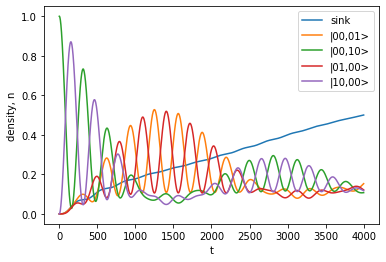

In [8]:
basis_states = [np.array([0,0,0,0])] + define_basis(1)
basis_dim = len(basis_states)
print_basis(basis_states)

H = hamiltonian_jch(basis_states, g=0.01, mu=0.002)
E, v = eigensolver(H)
print('H eigenvalues:')
for i in range(0,basis_dim):
    print('[%3d] %12.8f' % (i, E[i]))

# initial guess: only the |00,11> state is populated
rho_0 = np.zeros((basis_dim,basis_dim))
rho_0[2,2] = 1.0

# leak operator matrices (from both cells)
A1 = np.zeros((basis_dim,basis_dim))
A2 = np.zeros((basis_dim,basis_dim))
for i in range(0,basis_dim):
    for j in range(0,basis_dim):
        A1[i,j] = annihil_photon(basis_states[i], basis_states[j], 2, 2, photon_index=0)
        A2[i,j] = annihil_photon(basis_states[i], basis_states[j], 2, 2, photon_index=1)
print('Leak matrix from the 1st cell:')
print(A1)
print('Leak matrix from the 2nd cell:')
print(A2)

gamma1 = 0.0005
gamma2 = 0.0002

def fun_leak_both(rho,gamma):
    A1conj = np.transpose(A1)
    A1conjA1 = np.matmul(A1conj, A1)
    A2conj = np.transpose(A2)
    A2conjA2 = np.matmul(A2conj, A2)
    L1 = gamma1 * (np.matmul(A1, np.matmul(rho, A1conj)) - 0.5 * (np.matmul(A1conjA1, rho) + np.matmul(rho, A1conjA1)))
    L2 = gamma2 * (np.matmul(A2, np.matmul(rho, A2conj)) - 0.5 * (np.matmul(A2conjA2, rho) + np.matmul(rho, A2conjA2)))
    return (-1j)*(np.matmul(H, rho) - np.matmul(rho,H)) + L1 + L2

# dynamics
t = np.linspace(0,4000,4001)
rho_list = runge_kutta_4(t, basis_dim, fun_leak_both, rho_0, 0.0005)

# plot
for i in range(0,basis_dim):
    plt.plot(t, abs(rho_list[:,i,i]), label=basis_labels[i])
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('density, n')
plt.show()